In [1]:
import plotly.express as px
import pandas as pd
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [2]:
output_txt = "../output.txt"

In [3]:
f = open(output_txt, "r")
content = f.read()
periods = content.split("CURRENT PERIOD")[1:]


In [4]:
regex_assignment = re.compile(
    r"V(.*?)    (.*?)    (.*?)    (.*?)    (.*?)    (.*?)    (.*?)    (.*?)    (.*?)    (.*?\(.*?\))    (.*?\(.*?\))    (.*?\(.*?\))    (.*?\(.*?\))"
)

In [5]:
final_d = {}

i = 1
for p in periods:
    matches = re.findall(regex_assignment, p)
    aux = []
    for match in matches:
        d = {}
        d["P"] = i
        d["Victim"] = "V" + str(match[0])
        d["G"] = int(match[1])
        d["A"] = int(match[2])
        d["λ"] = float(match[3])
        d["Veh"] = match[5]
        d["Hos"] = match[7]
        d["App"] = float(match[8].split(" ")[0])
        d["S"] = float(match[9].split(" ")[0])
        d["F"] =float(match[-1].split(" ")[0])
        d["Dur"] = d["F"] - d["App"]
        d["Wait"] = d["S"] - d["App"]
        d["TS_S"] = match[9].split(" ")[1].strip("(").strip(")")
        d["TS_F"] = match[-1].split(" ")[1].strip("(").strip(")")
        aux.append(d)
        final_d["V" + str(match[0])] = d
    p_df = pd.DataFrame(aux)


    with pd.option_context('display.max_rows', None,'display.max_columns', None,):
        print(p_df)
        print()
    i += 1

      P Victim  G  A         λ Veh   Hos    App         S         F      Dur   
0     1     V1  3  1  5.104960  H2  MCC1  461.0   461.000   587.725  126.725  \
1     1     V2  3  3  5.104960  H1  MCC1  461.0   461.000   556.717   95.717   
2     1     V3  3  2  5.104960  A1  MCC1  461.0   461.000   581.511  120.511   
3     1     V4  3  2  5.104960  A2  MCC1  461.0   461.000   581.511  120.511   
4     1     V5  3  2  5.104960  A3  MCC1  461.0   461.000   571.288  110.288   
5     1     V6  2  2  0.895303  A4  MCC2  461.0   461.000   544.497   83.497   
6     1     V7  2  1  0.895303  A4  MCC2  461.0   544.497   628.419  167.419   
7     1     V8  2  1  0.895303  H1  MCC2  461.0   556.717   605.883  144.883   
8     1     V9  2  2  0.895303  A3  MCC2  461.0   571.288   642.024  181.024   
9     1    V10  2  2  0.895303  A1  MCC2  461.0   581.511   660.168  199.168   
10    1    V11  2  2  0.895303  A2  MCC2  461.0   581.511   656.802  195.802   
11    1    V12  2  2  0.895303  H2  MCC2

In [6]:
final_aux = []
for k in final_d:
    final_aux.append(final_d[k])
final_aux = sorted(final_aux, key=lambda d: d["S"])
final_df = pd.DataFrame.from_dict(final_aux)
with pd.option_context('display.max_rows', None,'display.max_columns', None,):
        print(final_df)
        print()

     P Victim  G  A         λ Veh   Hos     App         S         F      Dur   
0    7     V1  3  1  5.104960  A1  MCC1   461.0   461.000   610.226  149.226  \
1    7     V2  3  3  5.104960  H2  MCC1   461.0   461.000   556.717   95.717   
2    7     V3  3  2  5.104960  A2  MCC1   461.0   461.000   582.511  121.511   
3    7     V4  3  2  5.104960  H1  MCC1   461.0   461.000   559.496   98.496   
4    7     V5  3  2  5.104960  A3  MCC1   461.0   461.000   571.288  110.288   
5    7     V6  2  2  0.895303  A4  MCC2   461.0   461.000   544.497   83.497   
6    7     V7  2  1  0.895303  A4  MCC2   461.0   544.497   628.419  167.419   
7    7     V9  2  2  0.895303  H2  MCC2   461.0   556.717   593.783  132.783   
8    7    V10  2  2  0.895303  H1  MCC2   461.0   559.496   599.204  138.204   
9    7    V65  3  2  5.104960  A5  MCC1   566.0   566.000   664.753   98.753   
10   7    V66  3  2  5.104960  A3  MCC1   566.0   571.288   690.153  124.153   
11   7     V8  2  1  1.353050  A2  MCC5 

In [7]:
regex_unattended = re.compile(r"UNATTENDED VICTIM (.*?)\n")
unattended = periods[-1].split("Victims without assignment:")[-1]
no_hos_list = re.findall(regex_unattended, unattended)
final_df.drop(final_df[final_df['Victim'].isin(no_hos_list)].index, inplace = True)
final_df.reset_index(drop=True, inplace=True)
final_df.Victim

0        V1
1        V2
2        V3
3        V4
4        V5
       ... 
209    V207
210    V208
211    V209
212    V213
213    V214
Name: Victim, Length: 214, dtype: object

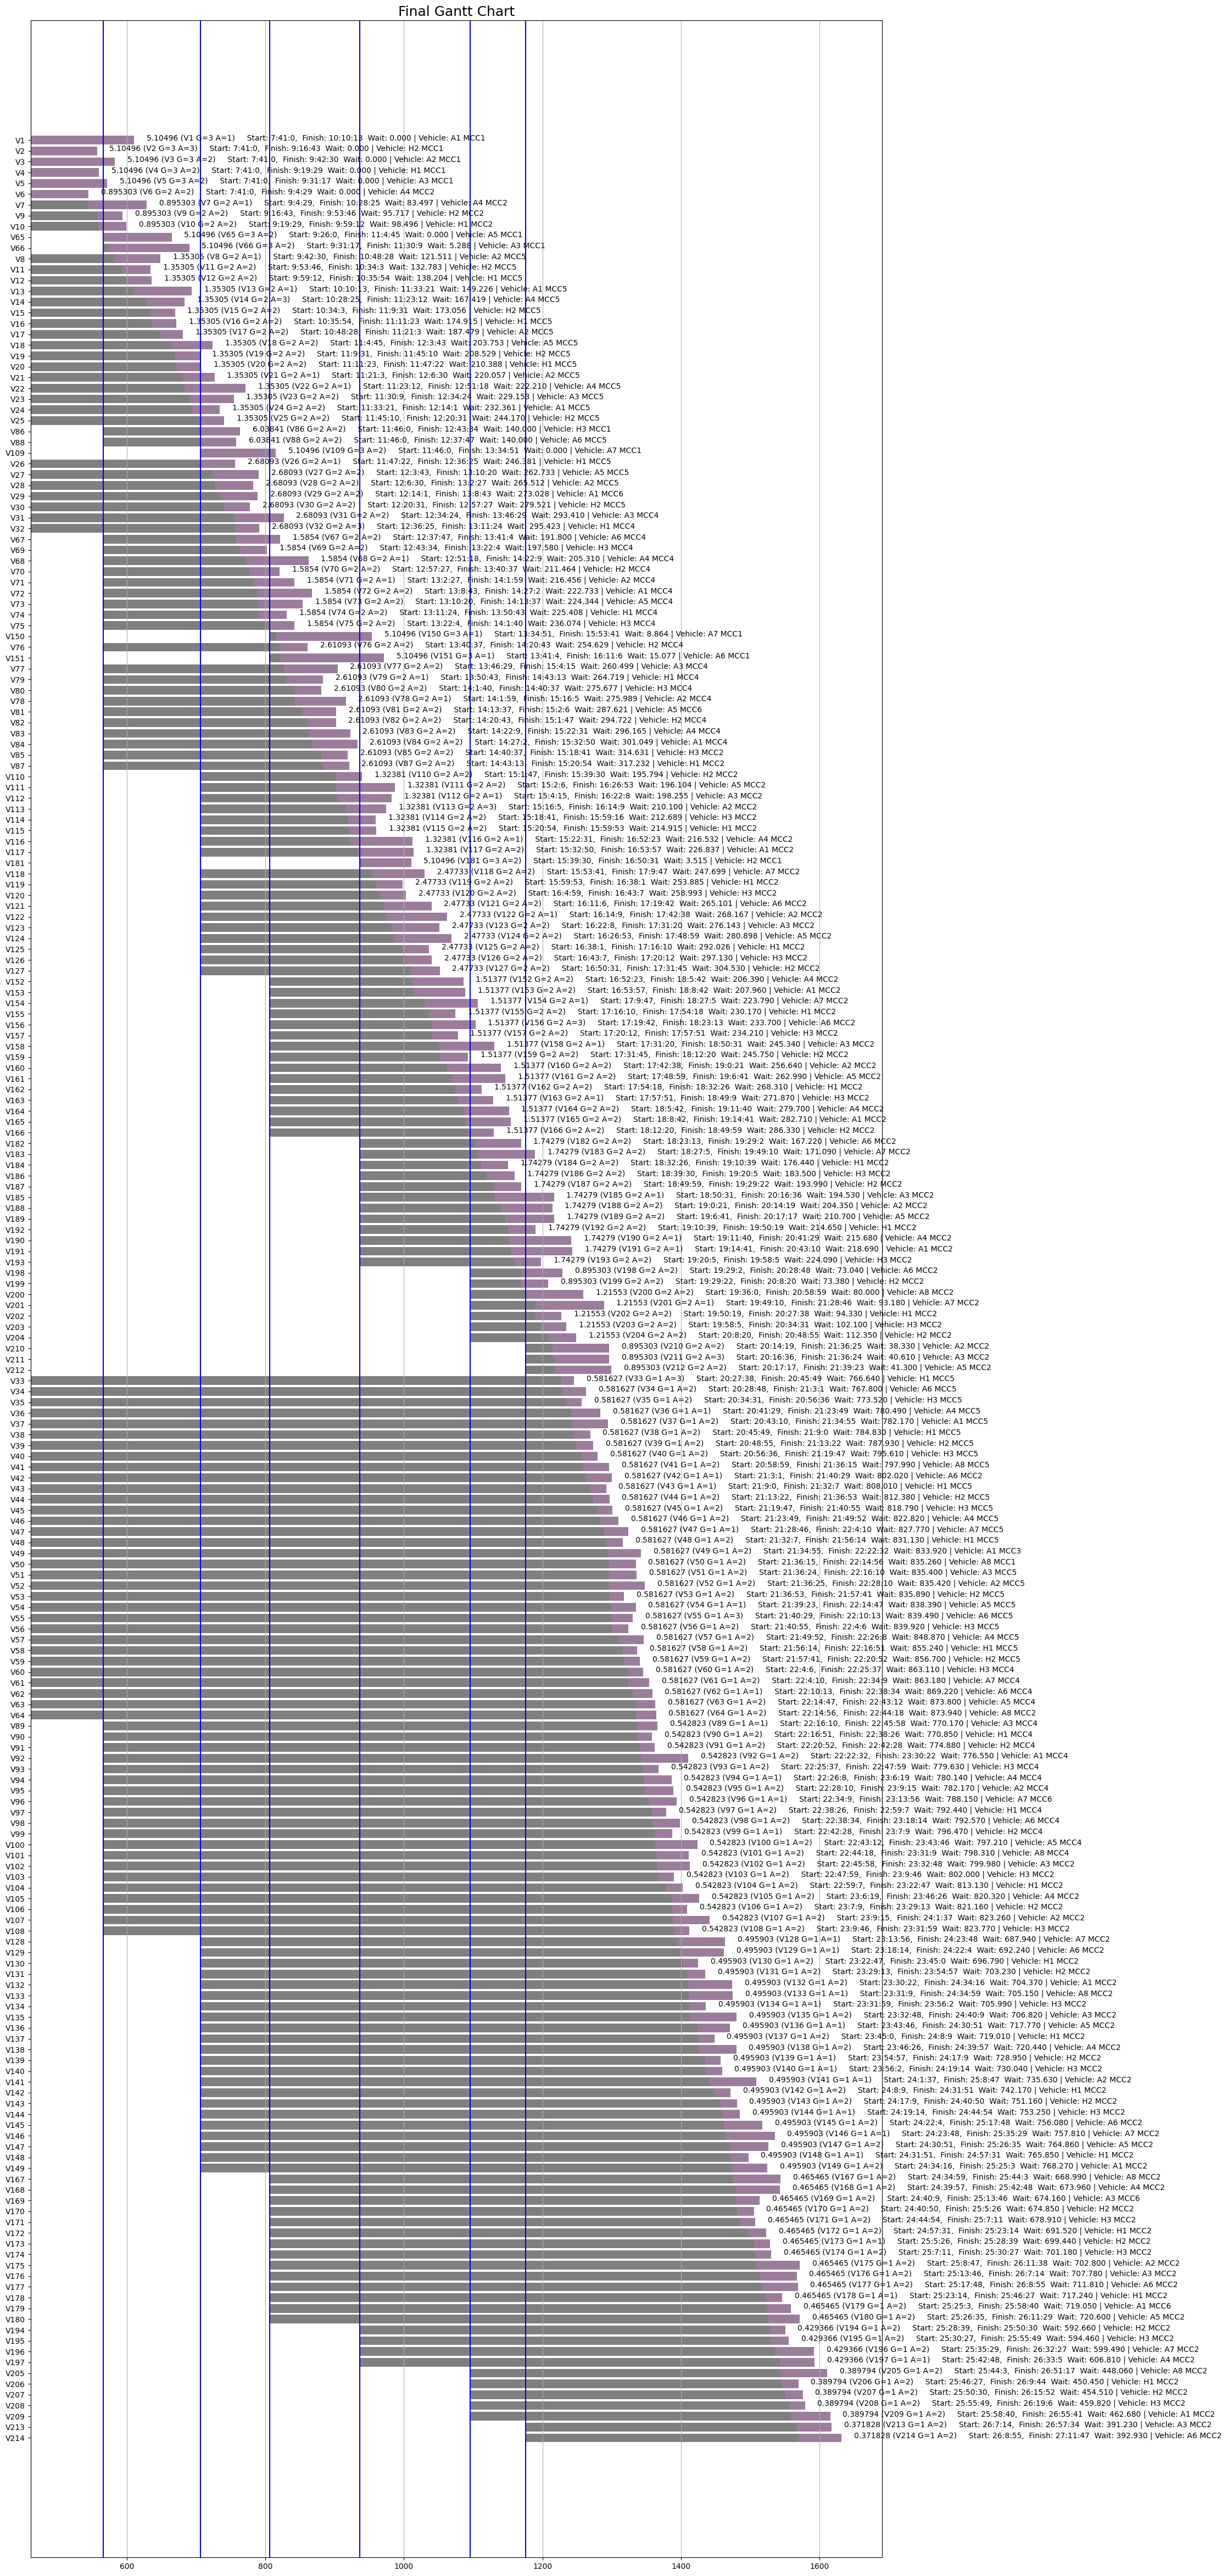

In [8]:
plt.figure(figsize=(20,60))
yticks=[i for i in range(len(final_df.Victim))]
plt.title('Final Gantt Chart', size=18)

for i in range(final_df.shape[0]):
    # do not draw unattended victims as they got left out
    plt.barh(y=final_df.Victim, left=final_df.App, width=final_df.Dur, alpha= 0.4)
    plt.barh(y=final_df.Victim, left=final_df.App, width=final_df.Wait, alpha=1)
    label =  str(final_df.λ[i]) + " (" + str(final_df.Victim[i])+ " G="+ str(final_df.G[i]) + " A=" + str(final_df.A[i]) + ")" +  "     Start: " + str(final_df.TS_S[i])+ ",  Finish: " + str(final_df.TS_F[i])
    label += "  Wait: " + str("{:.3f}".format(final_df.Wait[i]))
    label += " | Vehicle: " + str(final_df.Veh[i])  +  " " + final_df.Hos[i]
    plt.text(x=final_df.F[i] + 18, y=yticks[i],s=label)
    
plt.axvline(x = 461, color = 'b',)
plt.axvline(x = 566, color = 'b')
plt.axvline(x = 706, color = 'b')
plt.axvline(x = 806, color = 'b')
plt.axvline(x = 936, color = 'b')
plt.axvline(x = 1096, color = 'b')
plt.axvline(x = 1176, color = 'b')
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.show()

In [9]:

f.close()